# Singleモデルにおける画像の埋め込みとtopK計算用

In [36]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import load_model

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

In [3]:
import os
BASE_PATH = './dataset/T_Shirt_all/'

In [4]:
model_epoch = 99
ALPHA = 0.1
vec_length = 512

In [5]:
con_embNet = load_model('./model/T_Shirt/Single/a0.1/512/con_emb_e{}.h5'.format(model_epoch), compile=False)
shop_embNet = load_model('./model/T_Shirt/Single/a0.1/512/shop_emb_e{}.h5'.format(model_epoch), compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
f = open("./test_pairs.txt","rb")
test_pairs = pickle.load(f)

In [7]:
test_pairs[0]

[10696,
 ['./dataset/T_Shirt_all/id_00010696/comsumer_01.jpg',
  './dataset/T_Shirt_all/id_00010696/shop_01.jpg']]

In [8]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [9]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[10696, './dataset/T_Shirt_all/id_00010696/shop_01.jpg']
gallery length = 2032


In [10]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(2032, 512)
(2032,)


In [11]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict(np.expand_dims(img,axis=0))[0]

100%|██████████| 2032/2032 [00:27<00:00, 81.30it/s]


In [12]:
f = open('./model/T_Shirt/Single/a{}/{}/gallery{}.txt'.format(ALPHA,vec_length,vec_length),'wb')
pickle.dump(emb_vecs,f)

In [19]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [14]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(2032,)


In [15]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([10696., 23825., 17789., 22720.,  3304.])

In [31]:
N = 100

In [32]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 2032/2032 [00:56<00:00, 35.93it/s]


In [37]:
topN_id_list[0]

array([32662.,  9159., 29186., 22637., 24677., 17964., 22424., 10520.,
       15906.,  9433., 27039., 26937., 13293.,  5555., 15841., 20370.,
       32070., 20993., 29193., 14924., 23235., 19193., 17806., 14523.,
       11271., 24831., 25383.,  5825., 19643.,  1342.,  4837., 21702.,
       22907.,  9782.,  9026., 23298., 21064.,  8628., 22645.,  5149.,
       20855., 18902., 16748., 16793., 18661.,  7562., 14194., 20440.,
        6222., 11046., 25597., 30185., 29995.,   209., 16997., 11506.,
       13880., 14309., 21130., 26240., 19923., 12264.,  8656., 17951.,
       22968., 22565., 12064., 26856., 26384., 16786., 28817., 25962.,
       25836.,  4365., 22136., 25926.,  7915., 21342., 15885., 31091.,
       14640., 28681., 16115., 15529., 26227., 14098.,  2672., 23026.,
       21807., 16685., 14950., 19255., 29647., 21740.,   983., 16828.,
       23825., 10525., 24212., 14111.])

In [39]:
f = open('./model/T_Shirt/Single/a{}/{}/topN_id_list{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [22]:
f = open('./model/T_Shirt/Single/a{}/{}/query{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [24]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [25]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [35]:
f = open('./model/T_Shirt/topK/SingleTripletLoss_{}.txt'.format(vec_length), 'wb')
pickle.dump(topk_vals, f)

In [27]:
topk_vals

[0.014271653543307087,
 0.03297244094488189,
 0.045275590551181105,
 0.05610236220472441,
 0.0654527559055118,
 0.07529527559055119,
 0.08562992125984252,
 0.09498031496062992,
 0.10334645669291338,
 0.1141732283464567,
 0.1235236220472441,
 0.13484251968503938,
 0.140748031496063,
 0.15403543307086615,
 0.16289370078740156,
 0.17273622047244094,
 0.18061023622047245,
 0.1875,
 0.19389763779527558,
 0.2002952755905512,
 0.20521653543307086,
 0.2091535433070866,
 0.21653543307086615,
 0.22293307086614172,
 0.2312992125984252,
 0.23375984251968504,
 0.24163385826771652,
 0.24901574803149606,
 0.2573818897637795,
 0.26427165354330706,
 0.27017716535433073,
 0.2755905511811024,
 0.27903543307086615,
 0.2829724409448819,
 0.28789370078740156,
 0.29232283464566927,
 0.2987204724409449,
 0.30708661417322836,
 0.3125,
 0.3184055118110236,
 0.3203740157480315,
 0.3257874015748031,
 0.3302165354330709,
 0.3346456692913386,
 0.3395669291338583,
 0.343503937007874,
 0.3484251968503937,
 0.35187007

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


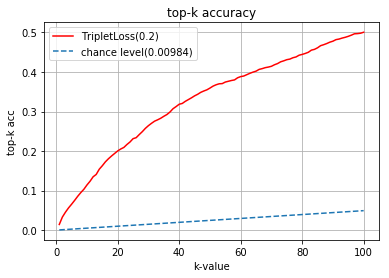

In [34]:
x = list(range(1,101))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()